<a href="https://colab.research.google.com/github/DataHustler/palagic/blob/master/AustinNLPproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

****

# Leveraging NLP and Nursing Notes to Improve Patient Outcomes and Reduce Readmission Rates #

In this notebook, I will be using the MIMIC-III dataset to machine learning techniques to analyze the natural languge used in nursing notes to determine is there is a relationship between the notes and the probability of readmission  for for patients with specific conditions within 30 days. The approach is designed to explore if using Natural Language Processing (NLP) techniques on nursing notes could identify the risk of readmission prior to discharge so caregivers could orchestrate interventions and/or adjust the careplan to optimize the patients outcome.  Six condition/procedure-specific 30-day risk-standardized unplanned readmission measures in the program:

1.   Acute Myocardial Infarction (AMI)
2.   Chronic Obstructive Pulmonary Disease (COPD)
3.   Heart Failure (HF)
4.   Pneumonia
5.   Coronary Artery Bypass Graft (CABG) Surgery
6.   Elective Primary Total Hip Athroplasty (THA)
7.   Total Knee Arthroplasty (TKA)



#Pre-processing and data setup

In order to get the environment configured to do the analysis, I chose to use [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) and [Google BigQuery](https://cloud.google.com/bigquery/). Physionet has enabled the MIMIC-III dataset to be available via BigQuery which significantly reduces the effort to get the data into a queryable state. It allows us to avoid the set-up and configuration of Database's as a service (aka DBaaS) instances of PostgressSQL or cloud IaaS infrastructure to run PostgressSQL. The instructions on how to set up MIMIC on BigQuery can be found [here.](https://mimic.physionet.org/tutorials/intro-to-mimic-iii-bq/)

Once you have completed the [required training](https://mimic.physionet.org/gettingstarted/access/), the authorized user can request access to BigQuery from a link in [data-set site](https://physionet.org/content/mimiciii/1.4/) once authenticated. The next step is to is to take the pinned data-set and make that available in your Jupyter notebook. Here is the turtorial on how to connect via the BigQuery API to the CoLab [notebook.](https://tech.aaronteoh.com/bigquery-colaboratory-basics/)



In [1]:
# Connecting and Authenticating Google BigQuery with pinned MIMIC-III authorized dataset to this notebook. 

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
# Once 

#Creating the dataframe from BigQuery
Once connected, we are able to call the BigQueryAPI from the notebook to execute queries agains the MIMIC database. 

Export a subset of the MIMIC-III dataset that includes core criteria, notably the following:

Logic to define what qualifies as a readmit:
SUBJECT_ID and ICUSTAY_ID and INTIME is chronologically later than the same (aka matching) SUBJECT_ID with ICUSTAY_ID OUTTIME 

Example of some readmission rate SQL 
https://github.com/YaronBlinder/MIMIC-III_readmission/blob/master/notebooks/1_create_dataframe.ipynb

In [0]:
#This block of code is using BigQuery to extract those patients who have the following inclusion criteria: is one of the 7 CMS target conditions; is a True Positive for 30day readmission.



In [37]:
# This query is to determine the first admit time for all patients that are included in the database. Once this is 
# established as a MIN value, we can do a subsetquent compare for same patient id with the readmit within 30days

%%bigquery --project hs619nlp --verbose readmitDF
SELECT p.subject_id, a.hadm_id, a.dischtime,
    a.admittime, p.expire_flag, a.insurance,
    MIN (a.admittime) OVER (PARTITION BY p.subject_id) AS first_admittime
FROM `physionet-data.mimiciii_clinical.admissions` a
INNER JOIN `physionet-data.mimiciii_clinical.patients` p
  ON p.subject_id = a.subject_id

Executing query with job ID: c387538c-2293-4af4-9ab2-76cd624a4aa4
Query executing: 3.95s
Query complete after 6.46s


In [4]:
# This query is to create the dataframe with the noteevents. For some reason this is crashing and I can not understand why, perhaps just too big.

%%bigquery --project hs619nlp --verbose noteeventsDF
SELECT n.subject_id, n.hadm_id, n.TEXT 
FROM `physionet-data.mimiciii_notes.noteevents` n LIMIT 10000

Executing query with job ID: 5f611c7c-7aa6-482f-aaa0-e49f83f58c56
Query executing: 0.44s
Query complete after 0.77s


NOTE TO SELF: the above query removed the use of legacy_sql which had the BigQuery API default to standard_sql I leanred this process from this blog post https://tech.aaronteoh.com/bigquery-colaboratory-basics/

Originally, I wanted to find a way to call the API and save a csv in Google Drive so I could have a persistent file which would be my source data. I did that manually from the BigQuery interface, but wanted to find a way to make it more repeatable in the jupyter notebook. The query above is creating the 'readmitDF' and allows me to shape that data here in the notebook. 


In [0]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
#This is just a quick way to validate the data that is going into the dataframe to calculate readmissions
readmitDF.shape


(58976, 7)

In [8]:
#This is validates the dataframe for NURSING NOTES TEXT
noteeventsDF.shape


(10000, 3)

In [40]:
#This block takes the two extracted dataframes and merges them together keying on hadm_ID as that is the patient unique identifier.
combinedNotesRedadmit= pd.merge(noteeventsDF, readmitDF, on='hadm_id', how='outer')
combinedNotesRedadmit.head()
combinedNotesRedadmit['lenghtofstay'] = combinedNotesRedadmit['dischtime'] - combinedNotesRedadmit['admittime']
combinedNotesRedadmit.head()

,subject_id_x,hadm_id,TEXT,subject_id_y,dischtime,admittime,expire_flag,insurance,first_admittime,lenghtofstay
0,86918.0,135138.0,TITLE:\n CVICU\n HPI:\n 66F s/p MVR(#31 ...,86918.0,2138-12-19 17:04:00,2138-12-02 16:09:00,0.0,Medicare,2138-12-02 16:09:00,17 days 00:55:00
1,99637.0,198033.0,CVICU\n HPI:\n 61M s/p AVR (29mm [**Compan...,99637.0,2116-05-23 13:40:00,2116-05-18 07:15:00,0.0,Private,2116-05-18 07:15:00,5 days 06:25:00
2,70373.0,149123.0,TITLE:\n CVICU\n HPI:\n HD2\n 67 yo s/...,70373.0,2115-12-31 15:05:00,2115-12-26 20:58:00,1.0,Private,2115-12-26 20:58:00,4 days 18:07:00
3,58261.0,144662.0,CVICU\n HPI:\n HD12\n [**3-27**] POD 1\n...,58261.0,2111-04-03 13:00:00,2111-03-16 17:41:00,0.0,Medicare,2111-03-16 17:41:00,17 days 19:19:00
4,76501.0,188262.0,TITLE:\n CVICU\n HPI:\n [**12-26**] POD ...,76501.0,2154-12-29 15:15:00,2154-12-25 13:00:00,0.0,Medicaid,2154-12-25 13:00:00,4 days 02:15:00


In [42]:
combinedNotesRedadmit['returned'] = combinedNotesRedadmit['admittime'] > combinedNotesRedadmit['dischtime']
combinedNotesRedadmit.head()


,subject_id_x,hadm_id,TEXT,subject_id_y,dischtime,admittime,expire_flag,insurance,first_admittime,lenghtofstay,returned
0,86918.0,135138.0,TITLE:\n CVICU\n HPI:\n 66F s/p MVR(#31 ...,86918.0,2138-12-19 17:04:00,2138-12-02 16:09:00,0.0,Medicare,2138-12-02 16:09:00,17 days 00:55:00,False
1,99637.0,198033.0,CVICU\n HPI:\n 61M s/p AVR (29mm [**Compan...,99637.0,2116-05-23 13:40:00,2116-05-18 07:15:00,0.0,Private,2116-05-18 07:15:00,5 days 06:25:00,False
2,70373.0,149123.0,TITLE:\n CVICU\n HPI:\n HD2\n 67 yo s/...,70373.0,2115-12-31 15:05:00,2115-12-26 20:58:00,1.0,Private,2115-12-26 20:58:00,4 days 18:07:00,False
3,58261.0,144662.0,CVICU\n HPI:\n HD12\n [**3-27**] POD 1\n...,58261.0,2111-04-03 13:00:00,2111-03-16 17:41:00,0.0,Medicare,2111-03-16 17:41:00,17 days 19:19:00,False
4,76501.0,188262.0,TITLE:\n CVICU\n HPI:\n [**12-26**] POD ...,76501.0,2154-12-29 15:15:00,2154-12-25 13:00:00,0.0,Medicaid,2154-12-25 13:00:00,4 days 02:15:00,False


In [55]:
positiveReadmitRows = combinedNotesRedadmit['insurance'] == "Medicare"
positiveReadmitRows = combinedNotesRedadmit['insurance'] == "Medicaid"
positiveReadmitRows = combinedNotesRedadmit['returned'] == True
positiveReadmit = combinedNotesRedadmit[positiveReadmitRows]
positiveReadmit.head()


,subject_id_x,hadm_id,TEXT,subject_id_y,dischtime,admittime,expire_flag,insurance,first_admittime,lenghtofstay,returned
763,28760.0,168303.0,Atrial fibrillation with slow ventricular resp...,28760.0,2167-01-14 12:00:00,2167-01-14 13:29:00,1.0,Medicare,2167-01-14 13:29:00,-1 days +22:31:00,True
1485,7094.0,180859.0,"Normal sinus rhythm, rate 80. Non-specific ant...",7094.0,2182-08-19 12:00:00,2182-08-19 16:35:00,0.0,Self Pay,2176-11-29 18:04:00,-1 days +19:25:00,True
1870,21272.0,156385.0,Normal sinus rhythm. Since the previous tracin...,21272.0,2162-09-25 01:23:00,2162-09-25 07:36:00,1.0,Medicare,2162-09-25 07:36:00,-1 days +17:47:00,True
2559,21033.0,188125.0,Normal sinus rhythm\nLeft atrial abnormality\n...,21033.0,2180-11-07 05:20:00,2180-11-07 18:32:00,1.0,Medicare,2180-11-07 18:32:00,-1 days +10:48:00,True
10209,NaN,102631.0,NaN,181.0,2153-10-12 06:29:00,2153-10-12 09:49:00,1.0,Private,2153-10-12 09:49:00,-1 days +20:40:00,True


In [56]:
positiveReadmit.shape

(98, 11)

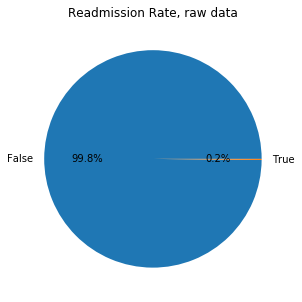

In [36]:
# pie chart to show readmit of the total number of HADM_id's
fig = plt.figure(figsize=(5,5))
combinedNotesRedadmit.returned.value_counts().plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Readmission Rate, raw data')
plt.ylabel('')
fig.savefig('readmissionChart.png')

#Setting up fast.ai
The project will utilize the fast.ai so we need to set that up in this notebook to use that. In addition, it is important to note that one needs to adjust the runtime to leverage GPU accelerators to execute this code. You can read about getting that set up here: https://course.fast.ai/start_colab.html


In [0]:
 #This is the line of code that sets up fast.ai in this notebook
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
#Next we need to import the libraries that will be used for some of the analysis

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import uuid


Once an Ngram is done then there are ways to do topic modeling; this is an unsupervised method to do clustering of information